# Let's recognise faces

## Naive Face Verification



### Packages needed



You have started by creating a virtual environment as per the readme.MD file. It eeds to be activated for this notebook!

Can install needed packages in the next cell.

In [1]:
%pip install -r requirements.txt

  Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached torchview-0.2.6-py3-none-any.whl.metadata (12 kB)
  Using cached torchgraph-0.0.0-py2.py3-none-any.whl.metadata (137 bytes)
  Using cached facenet_pytorch-2.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached pillow-11.1.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached pillow-10.2.0-cp312-cp312-macosx_11_0

Some Jupyter housekeeping

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Let's get an inception ResNet model trained with VGGface



Inception Model

https://arxiv.org/pdf/1409.4842v1

Neural network architecture codenamed Inception, which was responsible for setting the new state of the art for classification and detection in the ImageNet Large-Scale Visual Recognition Challenge 2014 (ILSVRC14)

![Why](meme.png)


Two different kinds of inception blocks

![module](module.png)

Output size stays the same regardless of kernel size

![Inception3D](inception3d.jpg)

Which combine into GoogleNet

![Summary](summary.png)

![Layers](layers.png)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from facenet_pytorch import InceptionResnetV1, MTCNN, extract_face
from torchview import draw_graph
from sklearn.manifold import TSNE
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import os
import math
import numpy as np

from IPython.display import display

Getting a resnet

In [4]:
resnet = InceptionResnetV1(pretrained="vggface2", classify=True).cpu().eval()

Visualise...

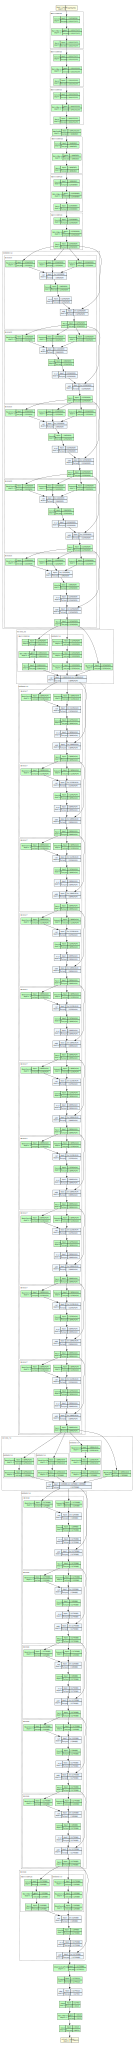

In [5]:
model_graph = draw_graph(
    resnet, input_size=(1, 3, 256, 256), expand_nested=True
)
model_graph.visual_graph

The way PyTorch describes it

In [6]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

We use a guillotine to create `resnet_vector` through the `tweaked_resnet` class:

In [7]:
class tweaked_resnet(nn.Module):
    """
    A decapitated resnet version

    The logits layer is removed from the resnet model
    """

    def __init__(self):
        super(tweaked_resnet, self).__init__()
        self.resnet = InceptionResnetV1(
            pretrained="vggface2", classify=True
        ).cpu()
        self.resnet.logits = nn.Identity()

    def forward(self, x):
        return self.resnet(x)

In [8]:
resnet_vector = tweaked_resnet()
resnet_vector.eval()

tweaked_resnet(
  (resnet): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True

Let's see how it looks like:

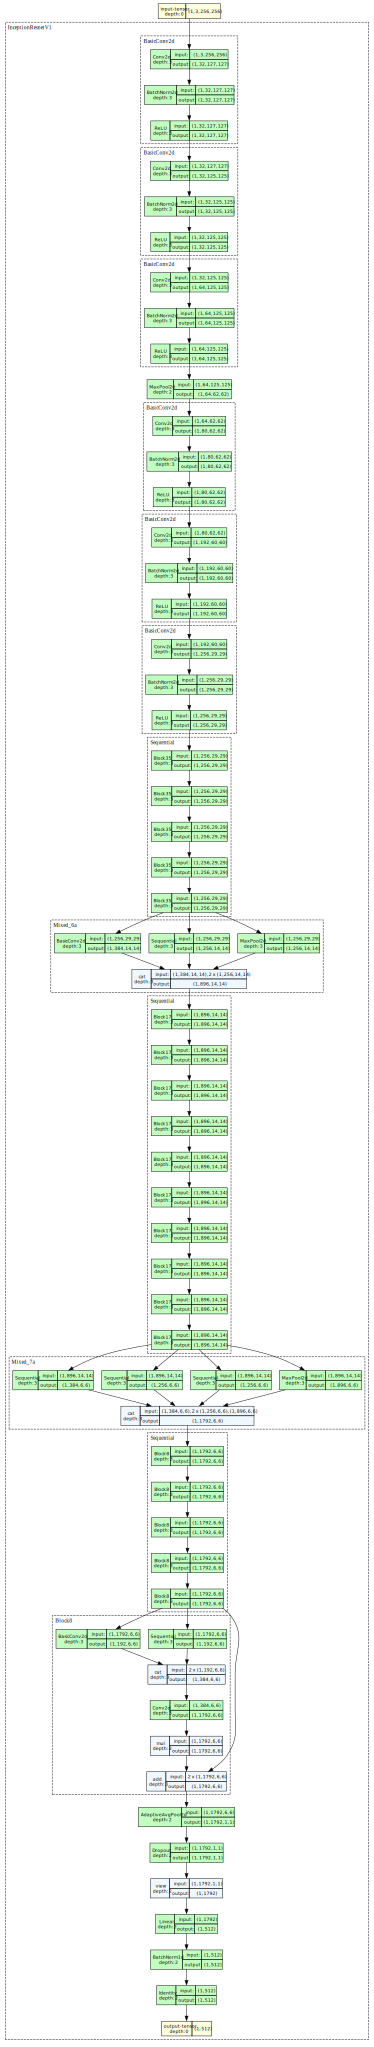

In [9]:
model_graph = draw_graph(
    resnet_vector,
    input_size=(1, 3, 256, 256),
    expand_nested=True,
)
model_graph.visual_graph

## Encoding images

A helper to transform, Multitask Cascaded Convolutional Networks for Face Detection and Alignment:

MTCNN uses a cascade of three networks to detect faces and facial landmarks:

* *PNet (Proposal Network)*: Scans the image and proposes candidate face regions.
* *RNet (Refine Network)*: Refines the face proposals from PNet.
* *ONet (Output Network)*: Detects facial landmarks (eyes, nose, mouth) and provides a final refinement of the bounding boxes.

In [10]:
mtcnn = MTCNN(select_largest=False)
mtcnn

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

We are using it as a helper but we are using the decapitated inception ResNet (`resnet_vector`) for the encoding:

In [11]:
def img_to_encoding(image_path, model, transform):
    """
    Convert any image into a 128-dimensional vector using the given model.
    """
    img = Image.open(image_path)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    with torch.no_grad():
        output = model(batch_t)  # here we get the 512-dimensional vector
    return (output, image_path)

We have a set of images in a folder:

In [12]:
FOLDER = "images"

We will start encoding a picture of Jason Chan:

<img src="images/chan1.png" style="width:250px;height:250px;">

In [13]:
CHAN1 = FOLDER + "/chan1.png"

jason_chan = img_to_encoding(CHAN1, resnet_vector, mtcnn)

Let's visualise what happened:

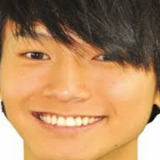

In [14]:
to_pil = torchvision.transforms.ToPILImage()
invert = torchvision.transforms.functional.invert

mtcnn2 = MTCNN(select_largest=False, post_process=False)
tensor = mtcnn2(Image.open(CHAN1))
img = invert(to_pil(tensor))
display(img)

The image above is after the transform (MTCNN), and below we get the vector:

In [15]:
print(jason_chan[0].shape)
print(jason_chan[0])

torch.Size([1, 512])
tensor([[ 1.0340, -0.7072, -0.3165,  0.5396, -0.6566,  0.4507, -0.3197, -0.2760,
         -1.3630,  0.6631, -0.1621,  1.3525,  0.6103,  1.5069, -0.4882, -0.8559,
         -0.1809,  1.1209, -0.3398, -0.2182, -0.4234,  0.0832,  0.6655, -0.4003,
          0.5517, -0.3938, -0.8509, -0.2270, -0.3598, -0.7523,  1.4421, -0.3179,
          0.1626, -0.0440, -0.9037, -1.6358, -1.8792, -0.0203, -1.6825, -0.3378,
         -1.5341,  0.0680, -0.1728,  0.3805,  0.1254,  0.5560, -0.6354, -0.3996,
         -0.3140, -0.2468,  0.5767, -0.2968,  0.6995, -0.9709, -0.9885, -0.1950,
         -1.1054,  0.2290, -0.9065,  0.6288, -0.2014,  0.5981,  0.1387,  0.8573,
         -0.0138, -0.0209, -0.7938, -1.0865,  0.1756,  0.7170, -0.5440,  1.2231,
          0.1807,  0.5908,  0.6437, -0.5488,  0.2626, -0.7356,  2.1742,  0.9243,
         -0.0951, -0.6015, -0.3152, -0.3934,  0.5165,  0.4175,  0.4311,  0.8954,
         -1.3203, -0.4607,  0.0209, -1.0694,  1.2472, -0.0975,  0.0127, -0.3448,
       

Now let's encode a group of people!

In [16]:
database = {}
database["Sammy Sum"] = img_to_encoding(
    FOLDER + "/sum1.png", resnet_vector, mtcnn
)
database["Jason Chan"] = img_to_encoding(
    FOLDER + "/chan1.png", resnet_vector, mtcnn
)
database["Alex Fong"] = img_to_encoding(
    FOLDER + "/fong1.png", resnet_vector, mtcnn
)
database["Dada Chan"] = img_to_encoding(
    FOLDER + "/dada1.png", resnet_vector, mtcnn
)
database["Niki Chow"] = img_to_encoding(
    FOLDER + "/niki1.png", resnet_vector, mtcnn
)
database["Shiga Lin"] = img_to_encoding(
    FOLDER + "/shiga1.png", resnet_vector, mtcnn
)
database["Gillian Chung"] = img_to_encoding(
    FOLDER + "/gillian1.png", resnet_vector, mtcnn
)
database["Charlene Choi"] = img_to_encoding(
    image_path=FOLDER + "/choi1.png", model=resnet_vector, transform=mtcnn
)

A small helper here to visualise images in a folder:

In [17]:
def show_images_in_folder(
    folder, transformed=True, sigourney=True, last_number=""
):
    """
    Show all images in a folder.
    Can filter Sigourney Weaver images.
    Returns a list of vectors and image filenames.
    """
    image_files = [
        f
        for f in sorted(os.listdir(folder))
        if f.endswith((last_number + ".png"))
    ]
    if not sigourney:
        image_files = [f for f in image_files if not f.startswith("sig")]

    images_per_row = 6
    _, axes = plt.subplots(
        math.ceil(len(image_files) / images_per_row),
        images_per_row,
        figsize=(7, 4),
    )
    axes = axes.flatten()

    files_list, vectors_list = [], []
    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(folder, image_file)
        if transformed:
            img = invert(to_pil(mtcnn2(Image.open(img_path))))
        else:
            img = Image.open(img_path)

        axes[idx].imshow(img)
        axes[idx].set_title(image_file)
        axes[idx].axis("off")
        vec, _ = img_to_encoding(img_path, resnet_vector, mtcnn)
        files_list.append(image_file)
        vectors_list.append(vec[0])

    for i in range(len(image_files), len(axes)):
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
    return np.array(vectors_list), files_list

The selection contained:

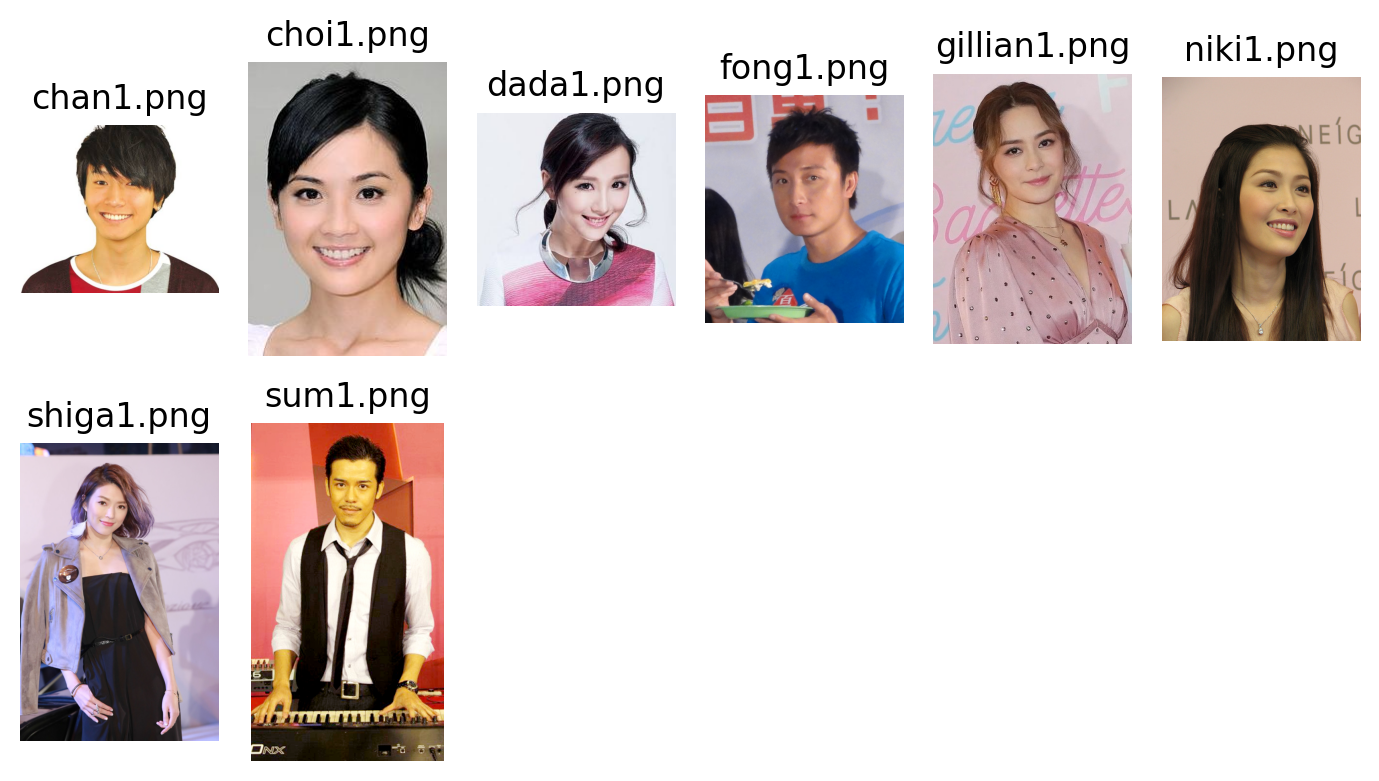

In [18]:
_, _ = show_images_in_folder(
    FOLDER, transformed=False, sigourney=False, last_number="1"
)

To quickly see what we have in the database now:

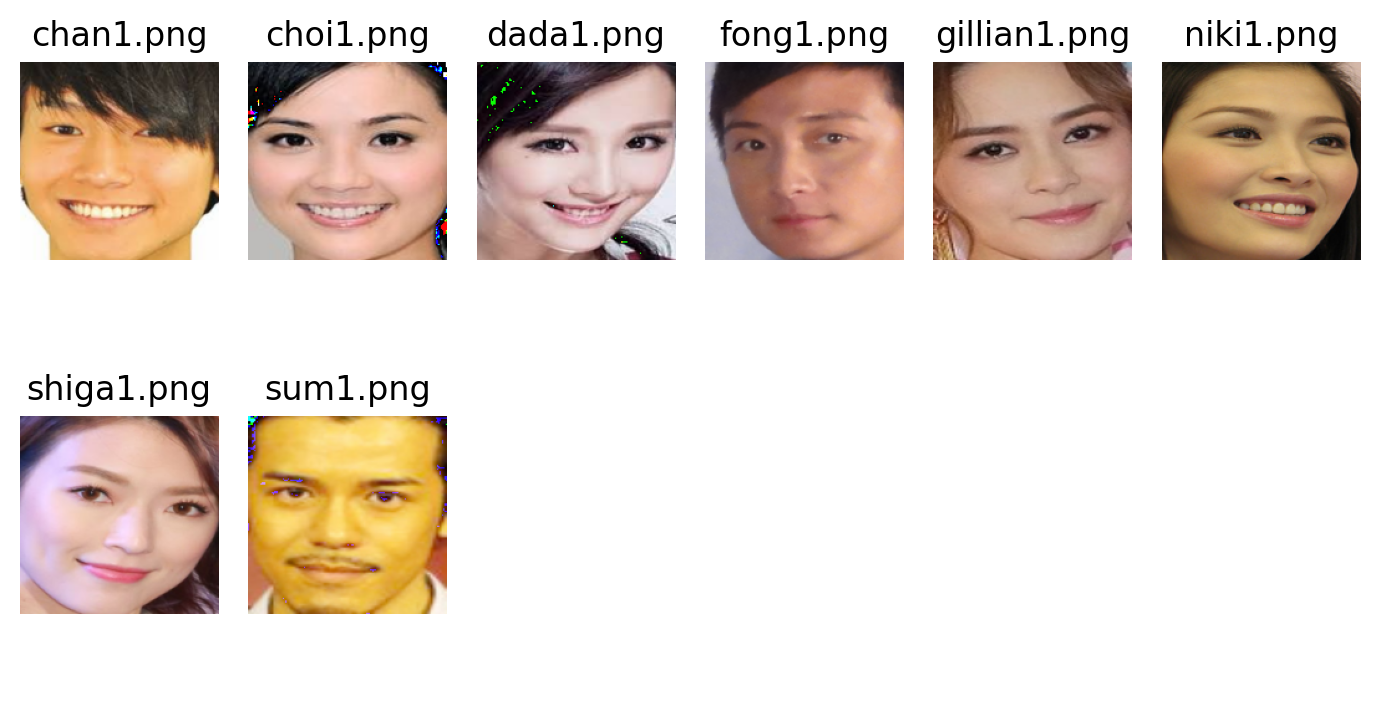

In [19]:
_, _ = show_images_in_folder(FOLDER, sigourney=False, last_number="1")

It seems we are ready to start recognising and verifying faces!

## The HK boys: identity verification

We are comparing the vector database entry with a specific vector

In [20]:
def verify(image_path, identity, database, model, transform):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    """
    encoding = img_to_encoding(image_path, model, transform)[0]

    # This is where we get the cosine similarity between the two vectors
    # Cosine similarity is working with angles, not magnitudes, and we get a value between -1 and 1
    # We want to get a dissimilarity value, so we take 1 - cosine similarity
    dist = 1 - F.cosine_similarity(database[identity][0], encoding)

    if dist < 0.5:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False

    return dist, door_open

In [21]:
def side_by_side(database_img, input_img):
    """
    Shows image and recognised image
    """
    to_pil = torchvision.transforms.ToPILImage()
    invert = torchvision.transforms.functional.invert
    mtcnn2 = MTCNN(select_largest=False, post_process=False)

    img1 = invert(to_pil(mtcnn2(Image.open(database_img))))
    img2 = invert(to_pil(mtcnn2(Image.open(input_img))))

    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes = axes.flatten()

    axes[0].axis("off")
    axes[0].imshow(img1)
    axes[0].set_title("Database")
    axes[1].axis("off")
    axes[1].imshow(img2)
    axes[1].set_title("Input")

    plt.tight_layout()
    plt.show()

Jason Chan is now trying to enter the office, this is how he looks like today:

<img src=FOLDER + "/chan2.png" style="width:250px;height:250px;">

In [22]:
CHAN2 = FOLDER + "/chan2.png"

distance, door_open_flag = verify(
    CHAN2, "Jason Chan", database, resnet_vector, mtcnn
)
print("(", distance, ",", door_open_flag, ")")

It's Jason Chan, welcome in!
( tensor([0.3787]) , True )


What did the system compare?

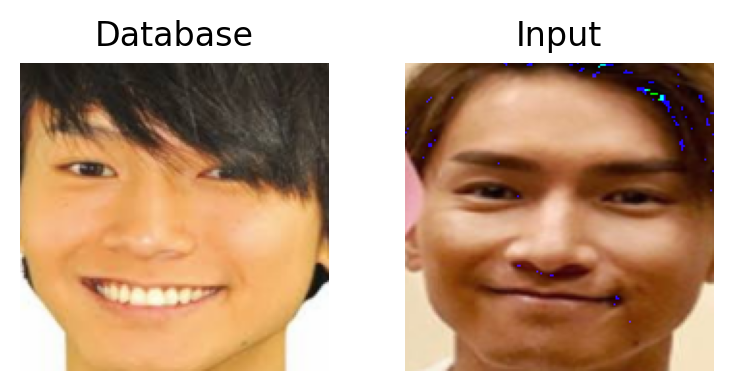

In [23]:
side_by_side(database["Jason Chan"][1], CHAN2)

Alex Fong is now trying to enter the office, but with Jason Chan's card... he's coming from the swimming pool today:

<img src="images/fong2.png" style="width:250px;height:250px;">

In [24]:
FONG2 = FOLDER + "/fong2.png"

distance, door_open_flag = verify(
    FONG2, "Jason Chan", database, resnet_vector, mtcnn
)
print("(", distance, ",", door_open_flag, ")")

It's not Jason Chan, please go away
( tensor([0.5790]) , False )


What did the system compare?

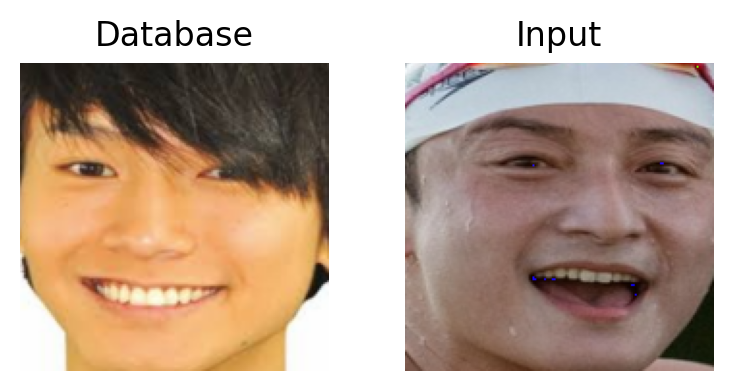

In [25]:
side_by_side(database["Jason Chan"][1], FONG2)

But he decides to put his real identity, still out of the pool!

In [26]:
distance, door_open_flag = verify(
    FONG2, "Alex Fong", database, resnet_vector, mtcnn
)
print("(", distance, ",", door_open_flag, ")")

It's Alex Fong, welcome in!
( tensor([0.2045]) , True )


What did the system compare?

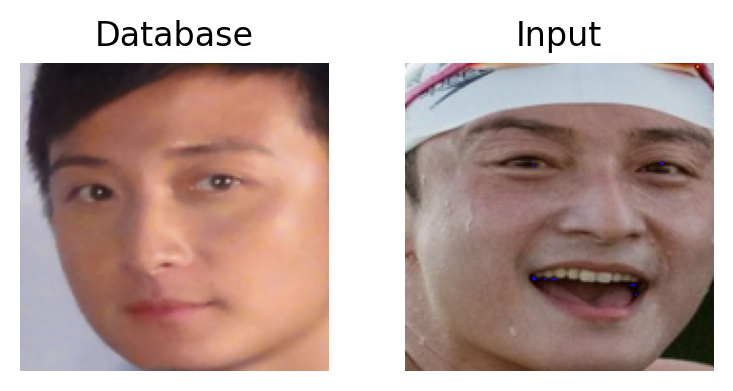

In [27]:
side_by_side(database["Alex Fong"][1], FONG2)

Then Sammy Sum shows up, happily:

<img src="images/sum2.png" style="width:250px;height:250px;">

In [28]:
SUM2 = FOLDER + "/sum2.png"

distance, door_open_flag = verify(
    SUM2, "Sammy Sum", database, resnet_vector, mtcnn
)
print("(", distance, ",", door_open_flag, ")")

It's Sammy Sum, welcome in!
( tensor([0.3212]) , True )


What did the system compare?

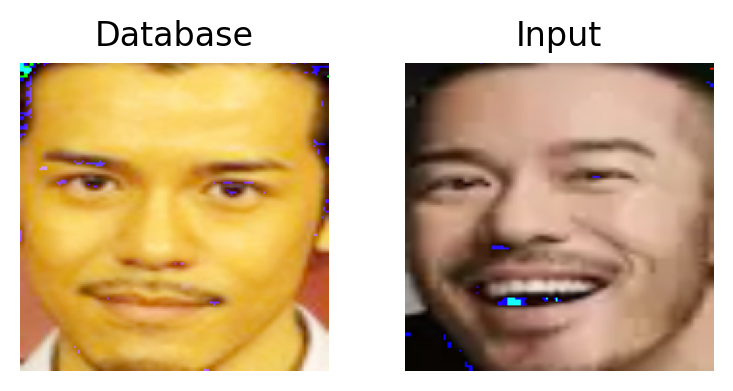

In [29]:
side_by_side(database["Sammy Sum"][1], SUM2)


## The HK girls: recognising a face

Now we are getting the closest entry in the vector database


In [30]:
def who_is_it(image_path, database, model, transform):
    """
    Implements face recognition
    """
    encoding = img_to_encoding(image_path, model, transform)[0]
    min_dist = 100
    for name, (db_enc, _) in database.items():
        dist = 1 - F.cosine_similarity(db_enc, encoding)
        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print("it's " + str(identity) + ", the distance is " + str(min_dist))
    return min_dist, identity

Dada Chan is now trying to enter the office:

<img src="images/dada2.png" style="width:250px;height:250px;">

In [31]:
DADA2 = FOLDER + "/dada2.png"

_, who = who_is_it(DADA2, database, resnet_vector, mtcnn)

it's Dada Chan, the distance is tensor([0.4290])


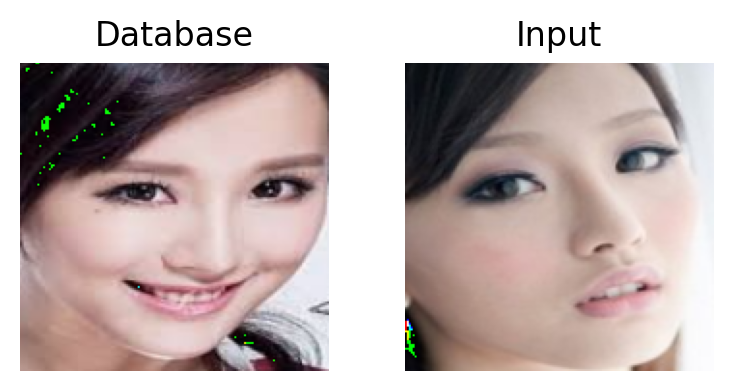

In [32]:
side_by_side(database[who][1], DADA2)

Gillian Chung is now trying to enter the office:

<img src="images/gillian2.png" style="width:250px;height:250px;">

In [33]:
GILLIAN2 = FOLDER + "/gillian2.png"

_, who = who_is_it(GILLIAN2, database, resnet_vector, mtcnn)

it's Gillian Chung, the distance is tensor([0.2512])


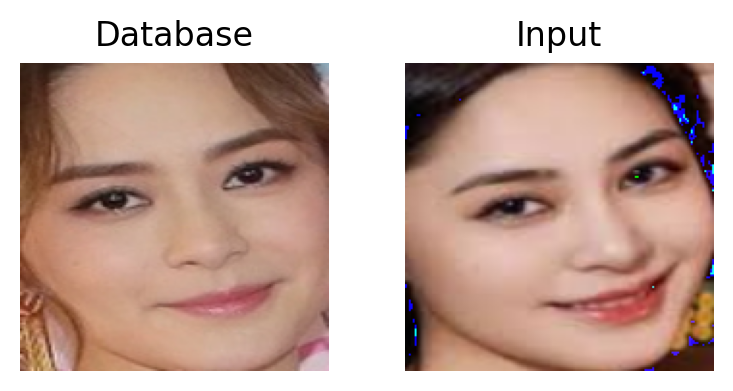

In [34]:
side_by_side(database[who][1], GILLIAN2)

And Shiga Lin

<img src="images/shiga2.png" style="width:250px;height:250px;">

In [35]:
SHIGA2 = FOLDER + "/shiga2.png"

_, who = who_is_it(SHIGA2, database, resnet_vector, mtcnn)

it's Shiga Lin, the distance is tensor([0.1874])


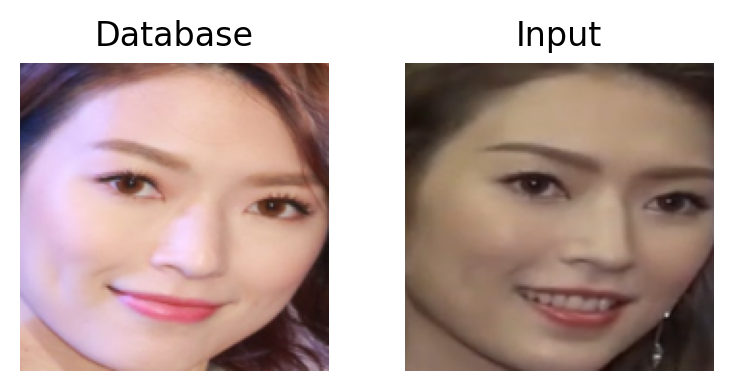

In [36]:
side_by_side(database[who][1], SHIGA2)

# Clustering the images

Naughty Sigourney Weaver has added herself to the HK team... maybe not?

The full folder:

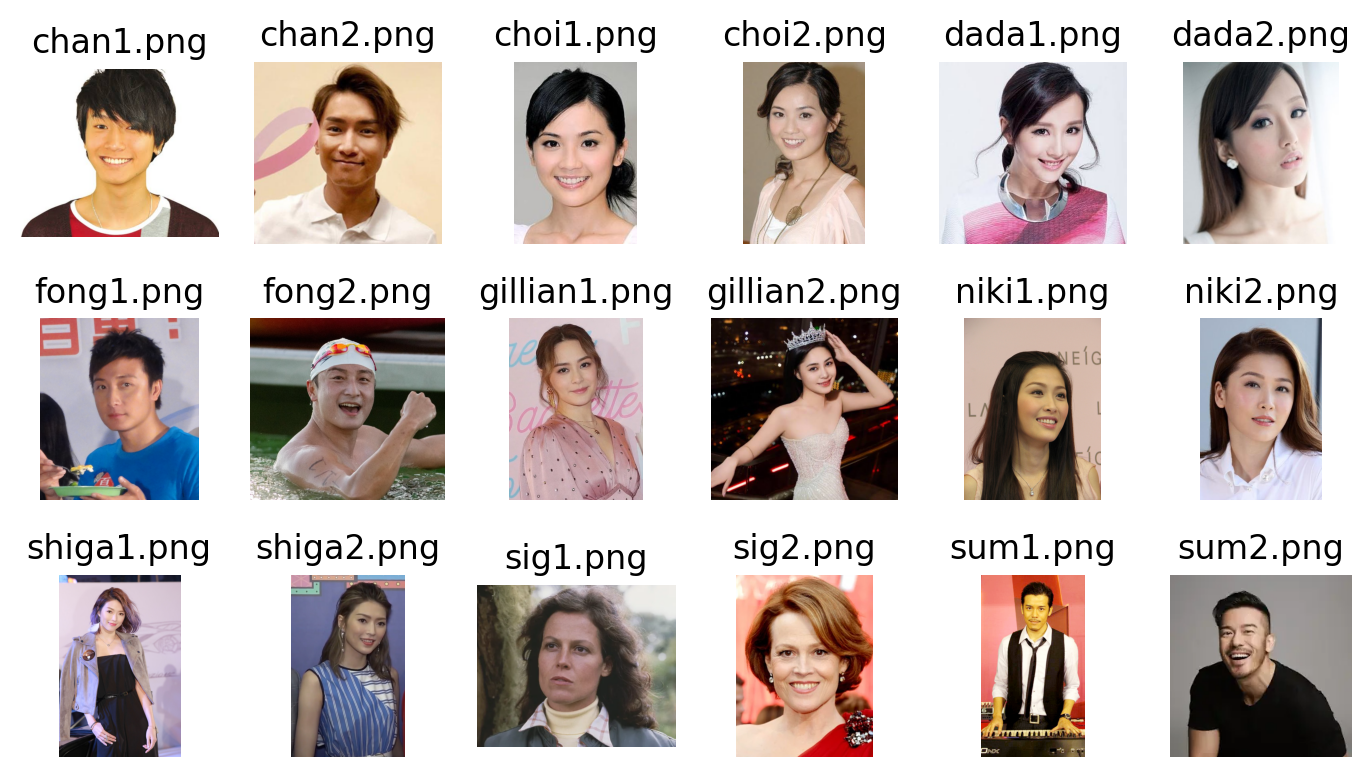

In [37]:
vectors, files = show_images_in_folder(FOLDER, transformed=False)

The full database:

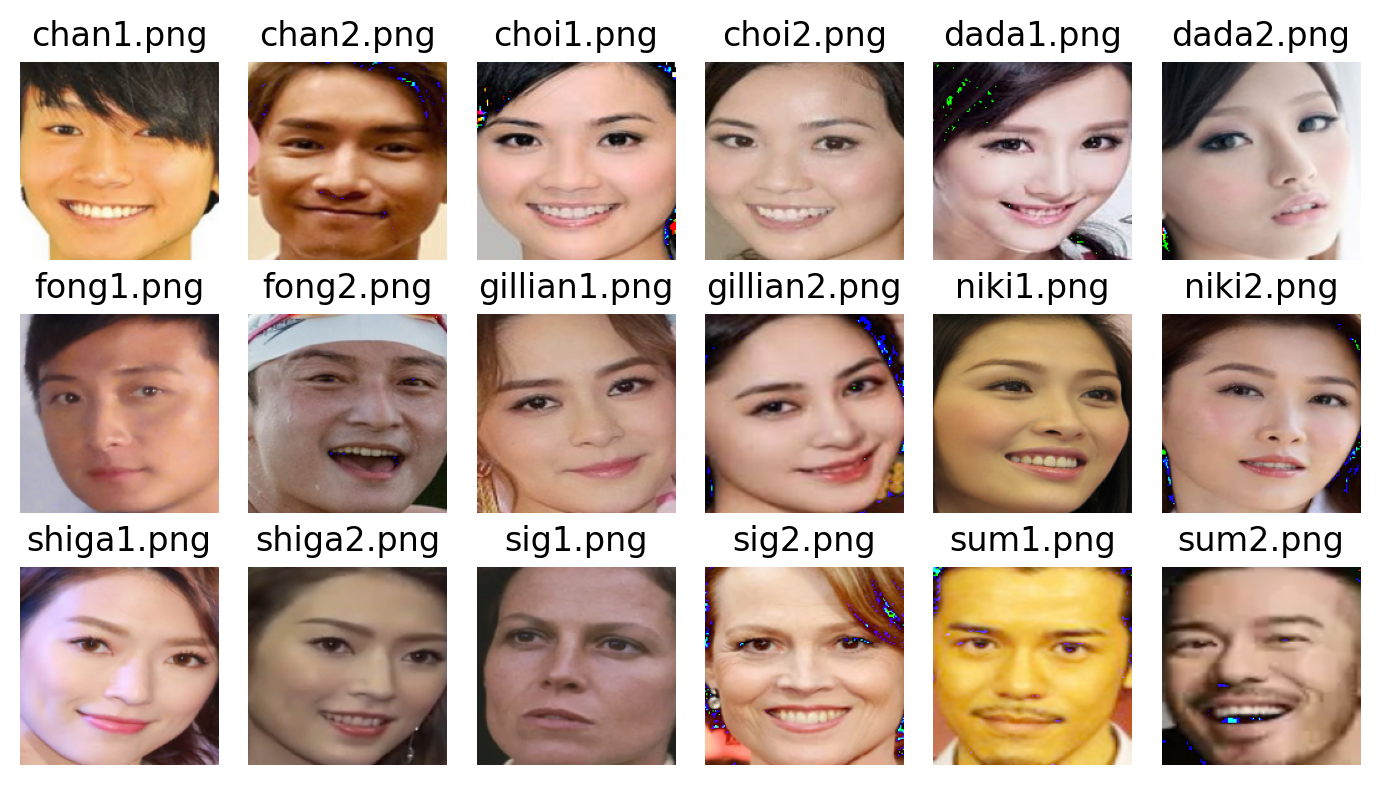

In [38]:
vectors, files = show_images_in_folder(FOLDER)

## Principal Component Analysis

PCA finds the directions of maximum variance in the data and projects the data onto those directions. 

This way we can see which vectors are close or far

Note that this is distance, which is NOT cosine similarity, but there is some correlation

In [39]:
def plot_2d(vectors_2d, files_list):
    """
    2D scatter plot of the images based on their position in a compact space
    """
    _, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

    for vec, image_file in zip(vectors_2d, files_list):
        img = invert(
            to_pil(mtcnn2(Image.open(os.path.join(FOLDER, image_file))))
        )
        ab = AnnotationBbox(
            offsetbox=OffsetImage(img, zoom=0.2),
            xy=vec,
            frameon=False,
            box_alignment=(0, 0),
        )
        ax.add_artist(ab)
    plt.show()

In [42]:
tensor = torch.tensor(vectors)
_, _, V = torch.pca_lowrank(tensor, q=2)
tensor_pca = tensor @ V[:, :2]

vectors.shape, tensor_pca.numpy().shape

((18, 512), (18, 2))

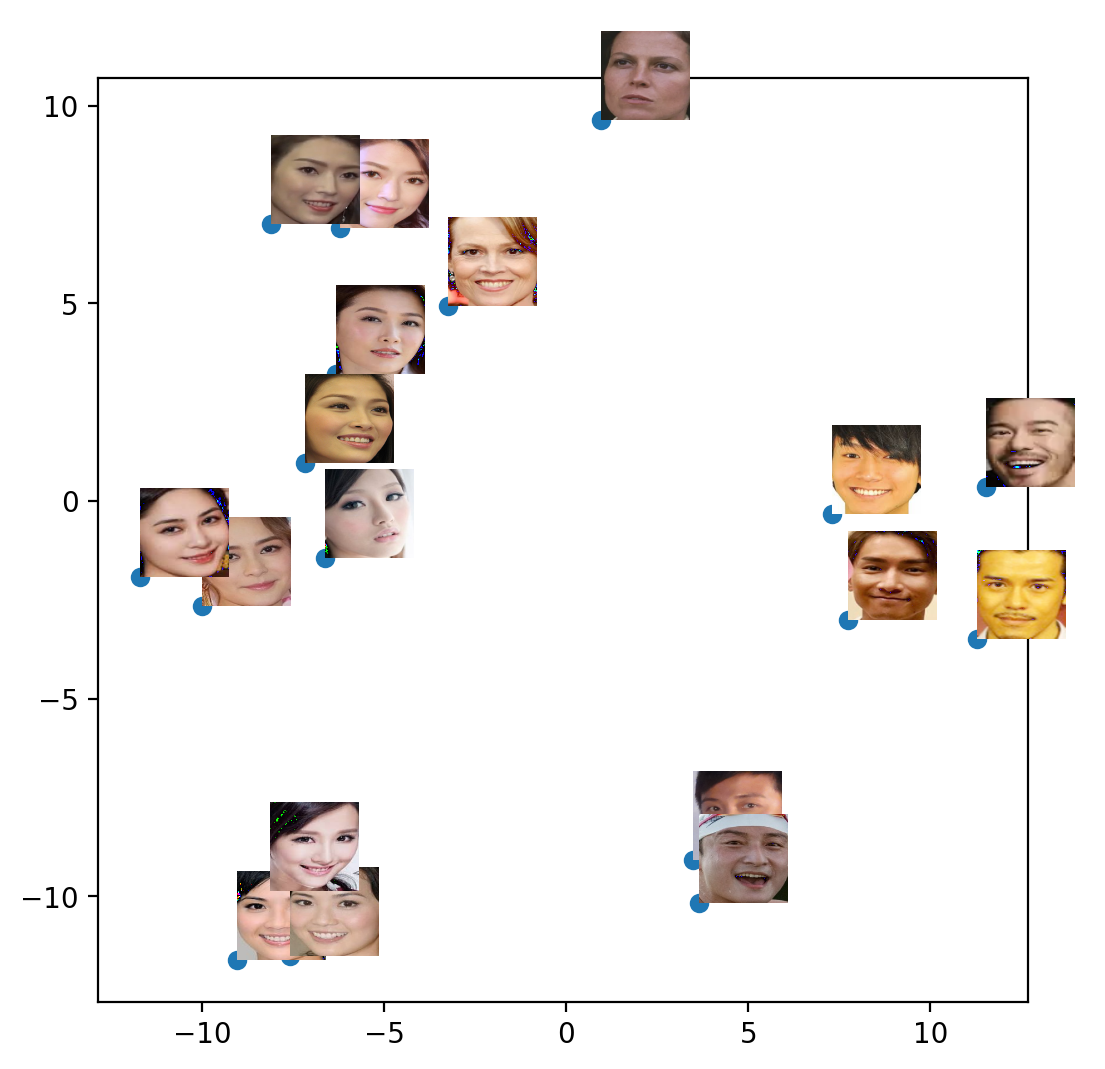

In [43]:
plot_2d(tensor_pca, files)

## t-SNE Dimensionality Reduction

t-distributed Stochastic Neighbor Embedding

* Converts Euclidean distances between points into probabilities using a Gaussian distribution in high-dimensional space.
* In low-dimensional space, it uses a Student's t-distribution to compute similarities, which helps mitigate the "crowding problem" by allowing more flexibility.

In [44]:
vectors_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(vectors)

vectors_embedded.shape

(18, 2)

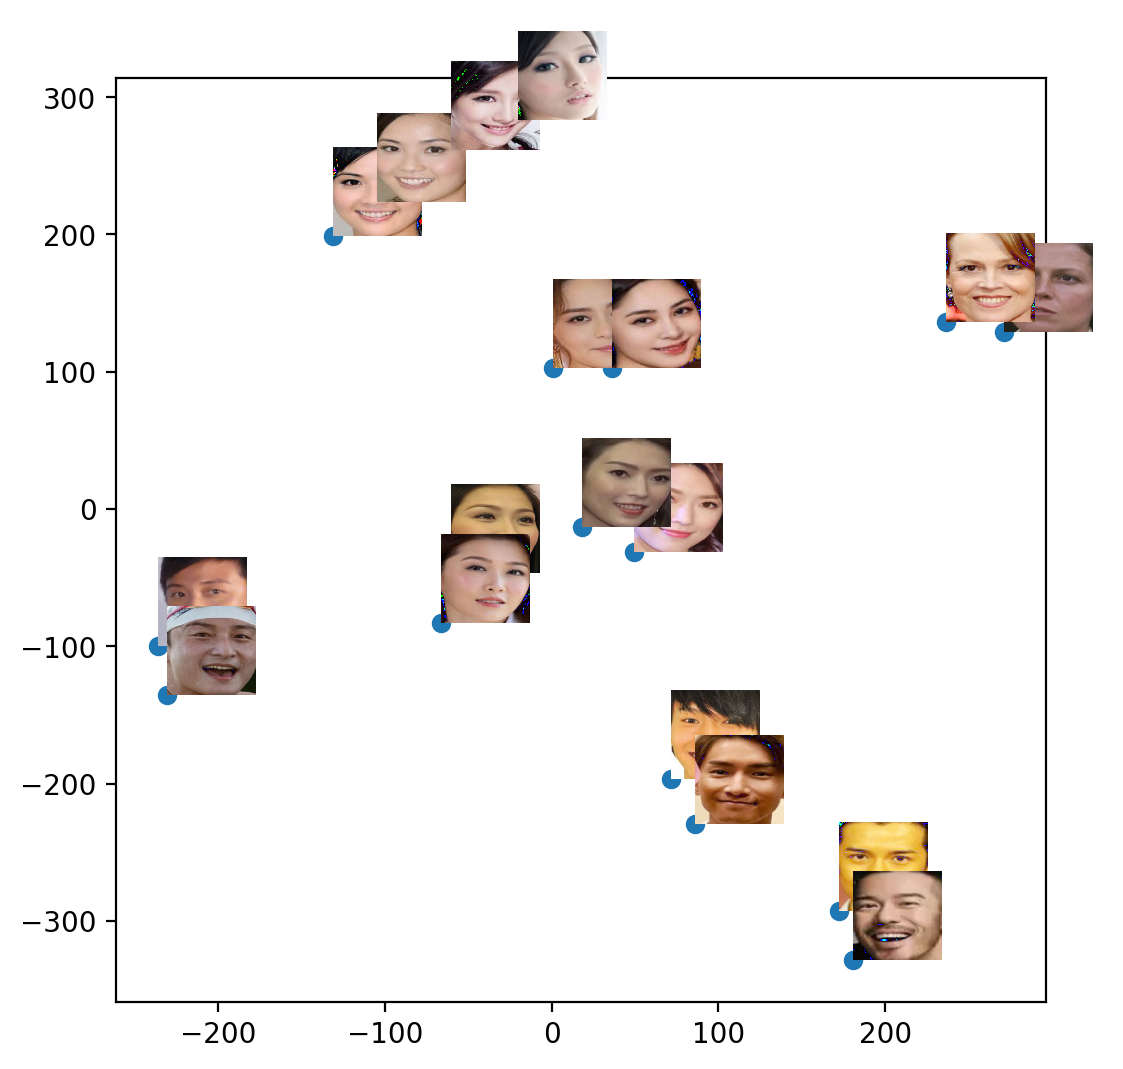

In [45]:
plot_2d(vectors_embedded, files)

And that's all folks!